In [1]:
# macro do ipython para rederizar o matplotlib inline
%matplotlib inline

# numpy é uma biblioteca de python que 
# nos permite fazer operações matriciais e vetoriais
# facilmente, e eficientemente (até um certo tamanho)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# from pylab import rcParams
# rcParams['figure.figsize'] = 15, 10

import time

import warnings
warnings.filterwarnings('ignore')

## MNIST (Reconhecimento de Digitos)

Vamos brincar um pouco com problema de reconhecimento de digitos. Usando o métodos de Árvore de Decisão, kNN e Gaussian Naive Bayes.

In [22]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")


X, y = mnist.data / 255., mnist.target

# amostragem para acelerar o treino
sample = np.random.choice(np.arange(60000), (30000), replace=False)

X_train, X_test = X[sample], X[60000:]
y_train, y_test = y[sample], y[60000:]

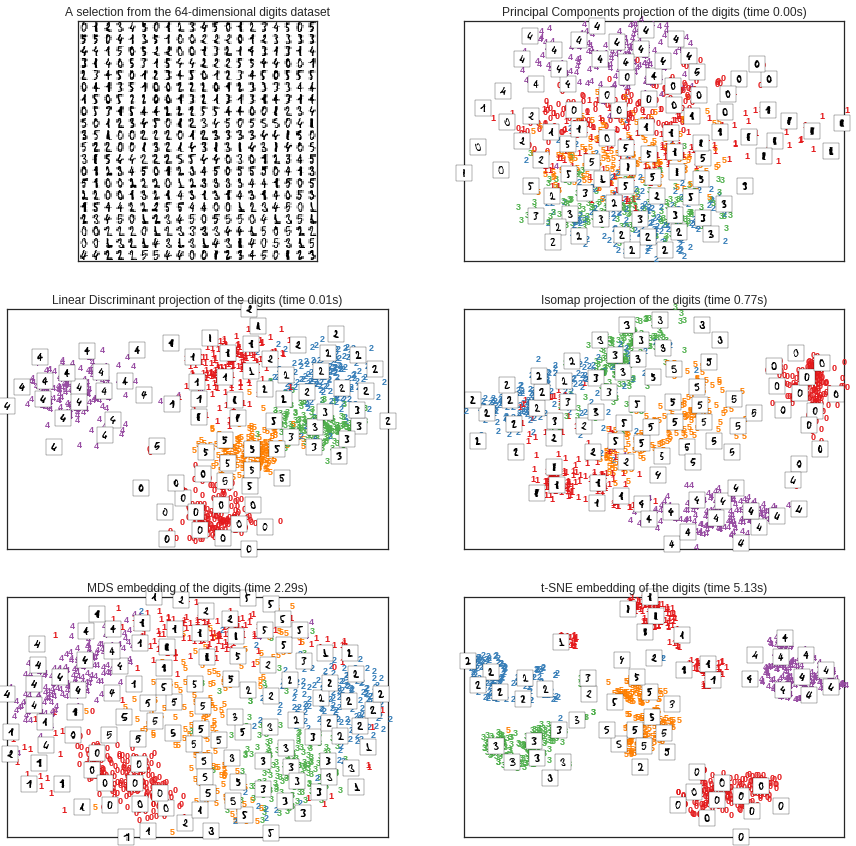

In [23]:
"""
Adaptação do exemplo do scikit-learn:
http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
"""
from time import time

from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

sns.set_style("white")

digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30


#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


plt.figure(figsize=(15,15))

ax = plt.subplot(321)
#----------------------------------------------------------------------
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')


ax = plt.subplot(322)
#----------------------------------------------------------------------
# Projection on to the first 2 principal components
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))


ax = plt.subplot(323)
#----------------------------------------------------------------------
# Projection on to the first 2 linear discriminant components
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X2, y)
plot_embedding(X_lda,
               "Linear Discriminant projection of the digits (time %.2fs)" %
               (time() - t0))


ax = plt.subplot(324)
#----------------------------------------------------------------------
# Isomap projection of the digits dataset
t0 = time()
X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))


ax = plt.subplot(325)
#----------------------------------------------------------------------
# MDS  embedding of the digits dataset
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (time() - t0))

ax = plt.subplot(326)
#----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score

clfs = [
    RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0),
    LinearSVC(dual=False, random_state=0), # melhor utilizar a forma primal (Num. atributos < Num. exemplos)
    SVC(random_state=0),
    AdaBoostClassifier(n_estimators = 500, learning_rate=0.1),
]

reducs = [
    decomposition.TruncatedSVD(n_components=20, random_state = 0),
    discriminant_analysis.LinearDiscriminantAnalysis(n_components=20),
    None
]

pipes = []
for reduc in reducs:
    for clf in clfs:
        if reduc:
            pipe = make_pipeline(reduc,clf)
        else:
            pipe = make_pipeline(clf)
            
        pipes.append(pipe)
        t0 = time()    
        y_pred = pipe.fit(X_train, y_train).predict(X_test)
        t1 = time()
        print("(time %.2fs) %s + %s acurácia : %.2f" % (t1 - t0, 
                                                        type(reduc).__name__.lower(), 
                                                        type(clf).__name__.lower(), 
                                                        accuracy_score(y_test, y_pred)))
    print()
    print()

(time 5.99s) truncatedsvd + randomforestclassifier acurácia : 0.94
(time 2.13s) truncatedsvd + linearsvc acurácia : 0.87
(time 11.04s) truncatedsvd + svc acurácia : 0.97
(time 43.38s) truncatedsvd + adaboostclassifier acurácia : 0.72


(time 7.62s) lineardiscriminantanalysis + randomforestclassifier acurácia : 0.91
(time 4.25s) lineardiscriminantanalysis + linearsvc acurácia : 0.87
(time 11.97s) lineardiscriminantanalysis + svc acurácia : 0.92
(time 26.60s) lineardiscriminantanalysis + adaboostclassifier acurácia : 0.86


(time 7.49s) nonetype + randomforestclassifier acurácia : 0.96
(time 12.36s) nonetype + linearsvc acurácia : 0.91
(time 234.17s) nonetype + svc acurácia : 0.94
(time 231.39s) nonetype + adaboostclassifier acurácia : 0.82


